# Automated Software Improvement: A Machine Learning Solution
## First Iteration - Prop Stat Passed
### 2727141 Luke Skinner
### Supervisor: Dr Sandy Brownlee

## Overview

These notebooks contain all the work performed on the first iteration of the Machine Learning model(s) to help guide automated improvement of Software. The dataset provided for this iteration is "merged_stats_sb_17112020_amended.csv" (this was amended to fix an issue with a column which would have skewed a lot of the data) which is an aggregate of experimental results of edits performed on open source projects. This will include the first cycle of building an effective model. However, it is expected that this first iteration will not be sufficient for accurate results therefore the main goal of this iteration is to discover features which are important to both compiling and passing tests. These edits should be successful and when applied through Gin they should result in some reduction of runtime. Several Models will be made to target the two different styles of edits (line & statement). 

#### Imports

In [1]:
import seaborn as sns 
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib as plt
from scipy.stats import loguniform

#### Utility Functions

In [2]:
def cacl_adj_r2(r2, n, k):
    """
    Calculates the adjusted r2 score based on the following formula:
    Adjusted r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1). This is used to
    complement the original r2 score to give a better understanding of
    how the model explains variance of the predictor variables

    Parameters:
        r2 (float): The original r2 score (from sklearn)
        n (int): The number of observations
        k (int): The number of predictor variables

    Returns:
        adj_r2 (float): The adjusted r2 score 
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)
    

#### Load Dataset

In [3]:
df = pd.read_csv('data/merged_stats_sb_17112020_amended.csv')

## Proposed Model 2 - Proportion Stat Passed
## 1. Data Visualisation

In [8]:
df.corrwith(df['PropStatPassed']).drop('PropStatPassed')

MethodIndex                   0.217208
numLines                     -0.042901
numStatements                -0.038476
EditDensity                   0.025152
AveUseDefDist                 0.001108
NotDeclared                   0.046960
AveUseDefDist/MethodLength    0.043212
MedDefUseDist                -0.001371
MedUseDefDist/MethodLength    0.043978
CountLine                     0.012774
CompiledLine                  0.058006
PassedLine                    0.116268
CountStat                     0.012774
CompiledStat                  0.066687
PassedStat                    0.126357
PropLineCompiled              0.358018
PropLinePassed                0.563709
PropStatCompiled              0.754484
cyclomatic                   -0.028330
ncss                         -0.037633
npath                        -0.062924
cyc/length                    0.087491
ncss/length                  -0.045963
npath/length                 -0.068836
InstCoverage-missed           0.028304
InstCoverage-covered     

<AxesSubplot:xlabel='PropStatCompiled', ylabel='PropStatPassed'>

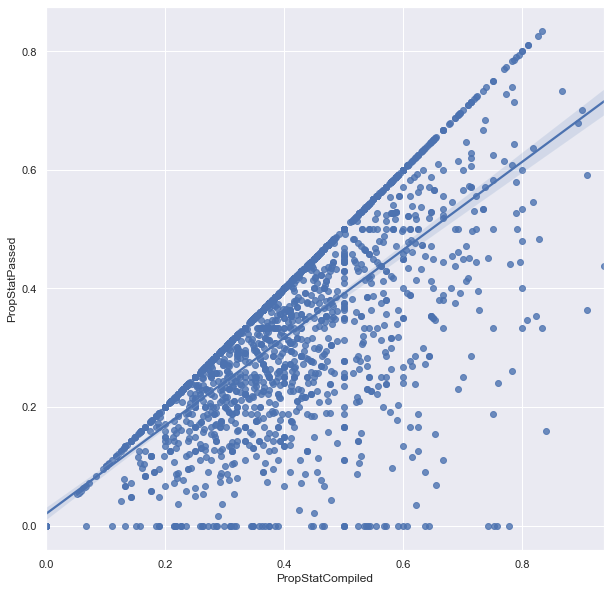

In [5]:
# Lets plot that using a regplot from seaborn
x_axis = df['PropStatCompiled']

y_axis = df['PropStatPassed']

sns.set(rc = {'figure.figsize' : (10, 10)})

sns.regplot(x=x_axis, y=y_axis)

## 2. Data Preparation

In [5]:
# Lets remove the non numerical fields as they are not useful for the model
df_new = df.drop(['CompositeKey', 'Project', 'MethodName', 'MethodIndex'], axis=1)

df_new.info() 

# We will filter out all rows which have a numLines < 10, we also want to only look at rows with sensible npath values
df_new = df_new[(df_new.numLines > 10) & (df.npath > -1)]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numLines                    2157 non-null   int64  
 1   numStatements               2157 non-null   int64  
 2   EditDensity                 2157 non-null   float64
 3   AveUseDefDist               2157 non-null   float64
 4   NotDeclared                 2157 non-null   int64  
 5   AveUseDefDist/MethodLength  2157 non-null   float64
 6   MedDefUseDist               2157 non-null   float64
 7   MedUseDefDist/MethodLength  2157 non-null   float64
 8   CountLine                   2157 non-null   int64  
 9   CompiledLine                2157 non-null   int64  
 10  PassedLine                  2157 non-null   int64  
 11  CountStat                   2157 non-null   int64  
 12  CompiledStat                2157 non-null   int64  
 13  PassedStat                  2157 

## 3. Beginning Train/Test split

##### We now want to identify the features which are most important, we will start by looking at all the other fields with respect to the target. First we will split the data 70%/30%.

In [6]:
X = df_new.drop(['PropStatPassed'], axis=1)

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(647, 26)
(278, 26)
(647,)
(278,)


## 4. Feature Importances at a glance

##### To get the feature importances, we will first start by fitting an overall RandomForest model on the data and seeing what it produces as feature importances. This will not be the final model.

PassedStat              0.574269
PropStatCompiled        0.251742
CountLine               0.034063
CountStat               0.033590
PropLinePassed          0.027236
CompiledStat            0.008760
CompiledLine            0.008337
InstCoverage-covered    0.006851
PropLineCompiled        0.005322
cyc/length              0.004845
dtype: float64


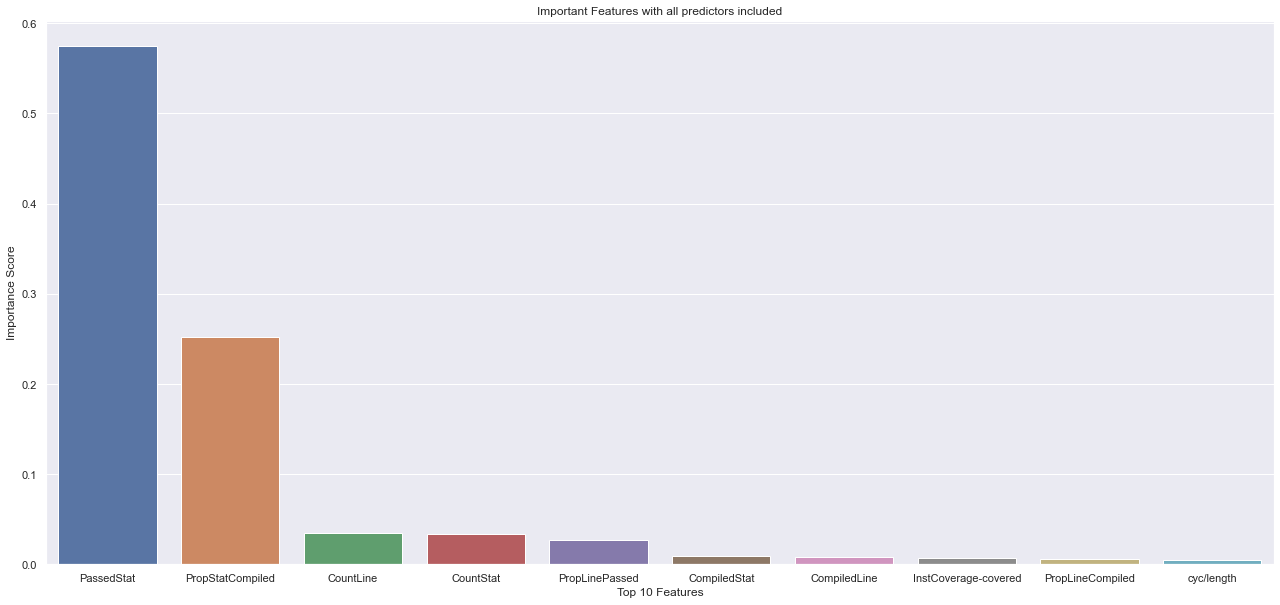

In [9]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features with all predictors included', xticklabels=top_10.index)

print(top_10)

In [10]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.91114
Adj. R2: 0.90849
RMSE: 0.00234
MAE: 0.03279


## 5. Feature Selection

##### After getting the initial result with all features included, let's see what happens when we drop certain features, starting with PassedLine.

In [23]:
# Building a model, dropping PassedLine
X = df_new.drop(['PropStatPassed', 'PassedStat'], axis=1)

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(628, 25)
(270, 25)
(628,)
(270,)


PropStatCompiled              0.493852
PropLinePassed                0.171149
PropLineCompiled              0.056244
InstCoverage-covered          0.037713
CompiledLine                  0.021935
ncss/length                   0.020396
PassedLine                    0.019052
CompiledStat                  0.018960
MedUseDefDist/MethodLength    0.015459
cyc/length                    0.014022
dtype: float64


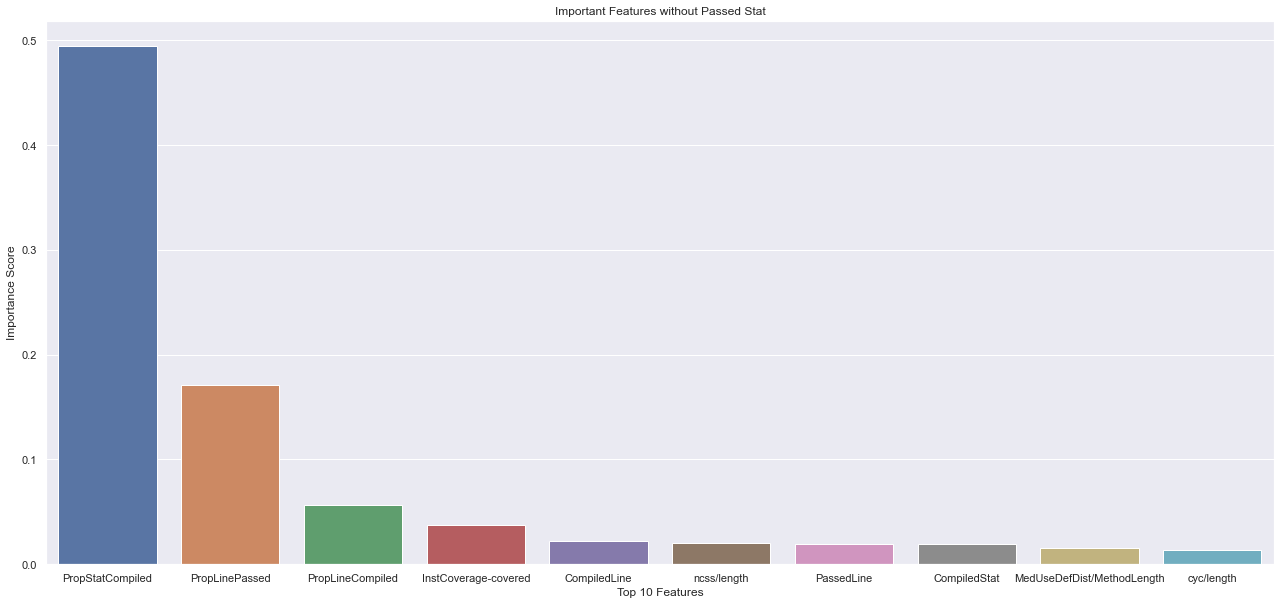

In [24]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features without Passed Stat', xticklabels=top_10.index)

print(top_10)

In [25]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.69091
Adj. R2: 0.68205
RMSE: 0.00812
MAE: 0.07069


In [8]:
# Building a model with just the metrics
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)


(628, 8)
(270, 8)
(628,)
(270,)


ncss/length      0.190254
AveUseDefDist    0.173922
cyc/length       0.166744
npath/length     0.130112
ncss             0.111382
dtype: float64


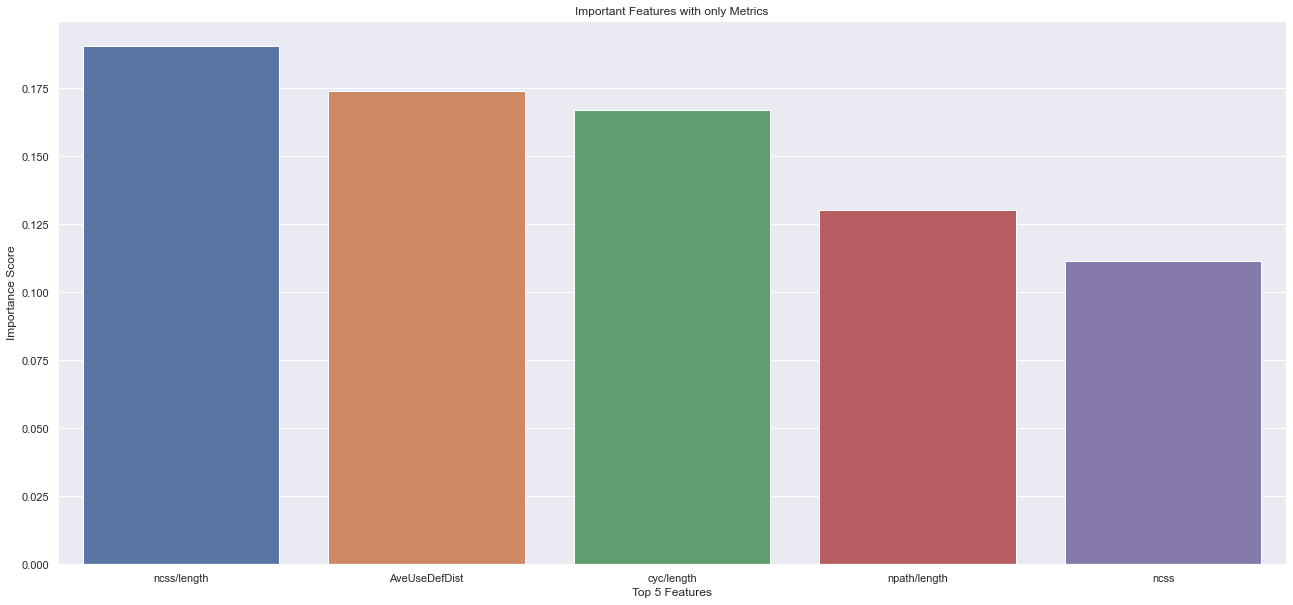

In [11]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(5)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (22, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 5 Features', ylabel='Importance Score', title='Important Features with only Metrics', xticklabels=top_10.index)

print(top_10)

In [16]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.02807
Adj. R2: 0.01932
RMSE: 0.02555
MAE: 0.12777


In [26]:
# Building a model where the related compile features are removed
X = df_new.drop(['PropStatPassed', 'PropStatCompiled', 'CompiledStat'], axis=1)

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(628, 24)
(270, 24)
(628,)
(270,)


PassedStat                    0.661574
PropLinePassed                0.110043
CountLine                     0.080628
CountStat                     0.078893
cyc/length                    0.008638
InstCoverage                  0.006888
MedUseDefDist/MethodLength    0.005591
InstCoverage-covered          0.005572
ncss/length                   0.004693
PropLineCompiled              0.004170
dtype: float64


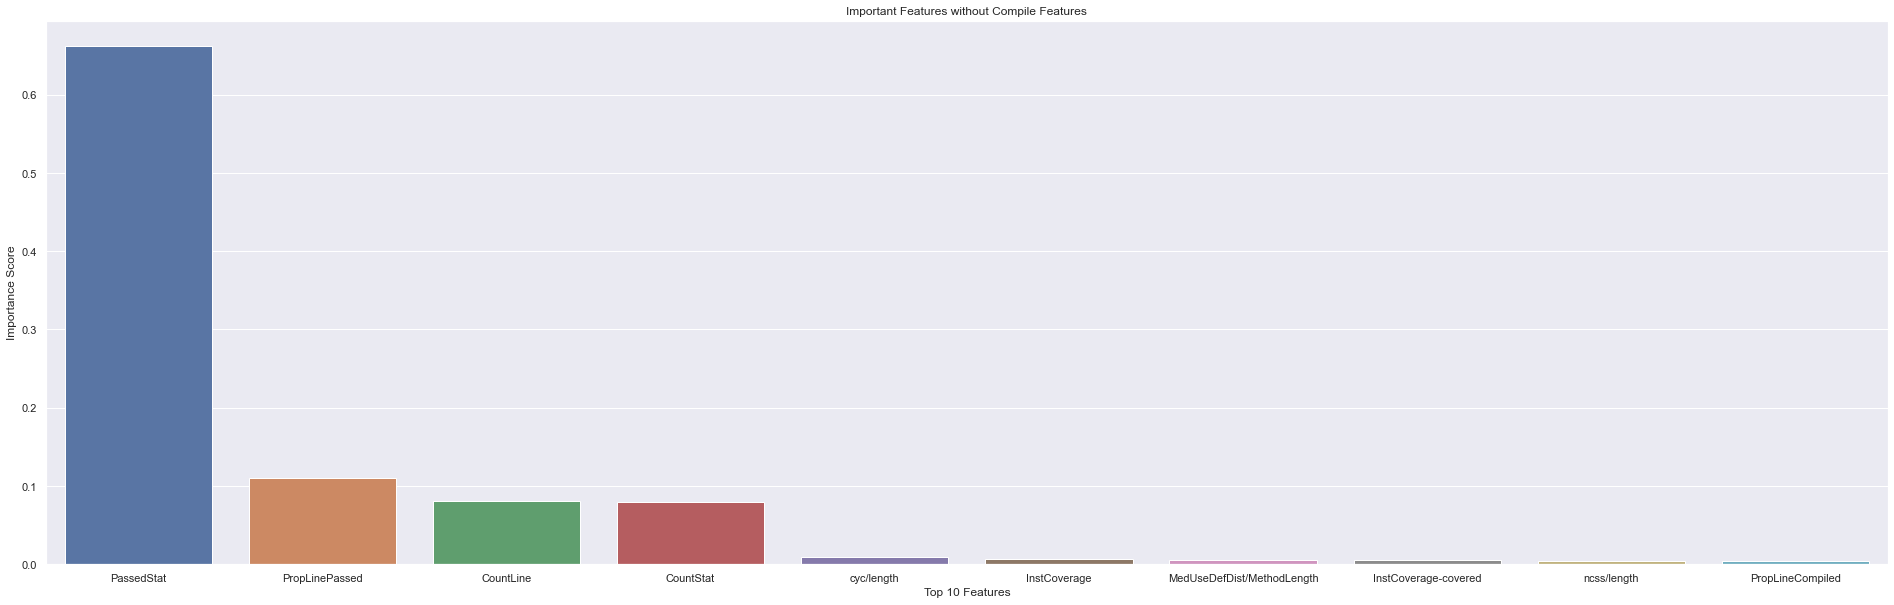

In [27]:
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

feature_importances = pd.Series(rforestreg.feature_importances_, index=X.columns)

top_10 = feature_importances.nlargest(10)

bar_x = [i for i in range(len(top_10))]

sns.set(rc = {'figure.figsize' : (33, 10)})

ax = sns.barplot(x=bar_x, y=top_10)

ax.set(xlabel='Top 10 Features', ylabel='Importance Score', title='Important Features without Compile Features', xticklabels=top_10.index)

print(top_10)


In [28]:
y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.89578
Adj. R2: 0.89291
RMSE: 0.00274
MAE: 0.03107


## 6. Model Evaluation

### 6.1.1 Ridge Regression without Tuning

In [8]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge() 

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")


R2 Score: -0.00354
Adj. R2: -0.01341
RMSE: 0.02565
MAE: 0.12727


### 6.1.2 Ridge Regression with Tuning

In [10]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
ridge = Ridge()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']

space['alpha'] = loguniform(1e-5, 100)

space['fit_intercept'] = [True, False]

space['normalize'] = [True, False]

# Define search
random_search = RandomizedSearchCV(ridge, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)



Random Search Best Score: -0.12191310547084536
Random Search Best Hyperparameters: {'alpha': 0.8165560864892165, 'fit_intercept': True, 'normalize': True, 'solver': 'cholesky'}


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [11]:
ridge = Ridge(solver='cholesky', fit_intercept=True, normalize=True, alpha=0.816556086489216)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.00868
Adj. R2: -0.00107
RMSE: 0.02534
MAE: 0.12586


C:\Users\lj\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


### 6.2.1 KNN without Tuning

In [19]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.13766
Adj. R2: -0.14919
RMSE: 0.01078
MAE: 0.08151


### 6.2.2 KNN with Tuning

In [29]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
knnreg = KNeighborsRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()

space['algorithm'] = ['ball_tree', 'kd_tree', 'brute']

space['n_neighbors'] = [2, 3, 5, 10, 12, 15, 20, 25, 30, 40]

space['weights'] = ['uniform', 'distance']

space['leaf_size'] = [10, 30, 60, 80, 90, 120, 140]

space['p'] = [1, 2, 3]

# Define search
random_search = RandomizedSearchCV(knnreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)

Grid Search Best Score: -0.010349092509619523
Grid Search Best Hyperparameters: {'algorithm': 'kd_tree', 'leaf_size': 60, 'n_neighbors': 40, 'p': 3, 'weights': 'uniform'}
Random Search Best Score: -0.07514895847833522
Random Search Best Hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 40, 'leaf_size': 140, 'algorithm': 'kd_tree'}


In [31]:
knnreg = KNeighborsRegressor(n_neighbors=40, weights='distance', p=1, leaf_size=140, algorithm='kd_tree')

knnreg.fit(X_train, y_train)

y_pred = knnreg.predict(X_test)

r2 = r2_score(y_test, y_pred)
    
adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.03733
Adj. R2: 0.02757
RMSE: 0.00912
MAE: 0.07192


### 6.3.1 RandomForest without Tuning

In [13]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")
print(rforestreg.get_params())

R2 Score: -0.06449
Adj. R2: -0.07496
RMSE: 0.02721
MAE: 0.13324
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### 6.3.2 RandomForest with Tuning

In [ ]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
rforestreg = RandomForestRegressor()

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()

space['n_estimators'] = [100, 250, 300, 350, 400, 450, 500]

space['bootstrap'] = [True, False]

space['warm_start'] = [True, False]

space['ccp_alpha'] = loguniform(1e-5, 100)

# Define search
random_search = RandomizedSearchCV(rforestreg, space, n_iter=800, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)

print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)


In [11]:
rforestreg = RandomForestRegressor(n_estimators = 100, warm_start=True, bootstrap=True, ccp_alpha=0.0002927184992304148)

rforestreg.fit(X_train, y_train)

y_pred = rforestreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -0.00551
Adj. R2: -0.01570
RMSE: 0.00953
MAE: 0.07313


### 6.4.1 MLPRegressor without Tuning

In [34]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor(max_iter=5500)

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: -6.91218
Adj. R2: -6.99001
RMSE: 0.20223
MAE: 0.19109


### 6.4.2 MLPRegressor with Tuning

In [36]:
X = df_new[['ncss', 'cyclomatic', 'npath', 'AveUseDefDist', 'MedDefUseDist', 'cyc/length', 'ncss/length', 'npath/length', 'NotDeclared']]

y = df_new['PropStatPassed']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=1)
mlpreg = MLPRegressor(max_iter=5500)

# Set up cross validation technique 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create Search space
space = dict()

space['hidden_layer_sizes'] = [(50,50,50), (50,100,50), (100,1), (100, 50, 1)]

space['activation'] = ['relu', 'tanh', 'logistic']

space['alpha'] = loguniform(1e-5, 100)

space['learning_rate'] = ['constant', 'adaptive']

space['solver'] = ['adam', 'lbfgs']

# Define search
random_search = RandomizedSearchCV(mlpreg, space, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)

# Fit search
random_search_result = random_search.fit(X_train, y_train)
                     
print('Random Search Best Score: %s' % random_search_result.best_score_)

print('Random Search Best Hyperparameters: %s' % random_search_result.best_params_)


Random Search Best Score: -0.12251674083662227
Random Search Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.48777805499545607, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [37]:
mlpreg = MLPRegressor(activation='tanh', alpha=0.48777805499545607, hidden_layer_sizes=(50, 100, 50), learning_rate='constant', solver='adam')

mlpreg.fit(X_train, y_train)

y_pred = mlpreg.predict(X_test)

r2 = r2_score(y_test, y_pred)

adj_r2 = cacl_adj_r2(r2, len(y), X.shape[1])

rmse = mean_squared_error(y_test, y_pred, squared=True)

mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.5f}\nAdj. R2: {adj_r2:.5f}\nRMSE: {rmse:.5f}\nMAE: {mae:.5f}")

R2 Score: 0.00757
Adj. R2: -0.00219
RMSE: 0.02537
MAE: 0.12848


C:\Users\lj\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
